In [1]:
# here we have a pipeline for running the reservoir with different connections present 
# it expectes to have output directories:  comparison/mod_input(True/False)mod_topo(True/False)shortcut(True/False)
# TrueTrueassociative, TrueTrueFalse,TrueTrueinput_driven

mod_input=True  #restrict input to first 300 units
mod_topo=True  # use the EDR structure
leak_rate = 0.2
gradient= 0.00075# 0.0005
gain = 1.75
radical="associative"  # options are "input_driven"  "associative" or False  #additional pathways
radical_bis=radical
grad2=1.25
breadth=600 #standard is 600
expon=3


# baseline with slow leak rate

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
import statsmodels.api as sm

import seaborn as sns

import csv

import scipy
from scipy import stats
from scipy.ndimage import gaussian_filter1d



Bad key text.latex.preview in file C:\Users\PeterDell\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\PeterDell\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\PeterDell\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.

In [5]:
#import cupy as cp
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import numpy as np
from wikipedia2vec import Wikipedia2Vec

vectorDim = 100

numNode = 1000

#inputDataTraining = np.load('./trainingData_averaging/inputDataTraining_4k_average.npy')
#outputDataTraining = np.load('./trainingData_averaging/outputDataTraining_4k_average.npy')
#print(len(inputDataTraining))
#print(len(outputDataTraining))

Using Numpy backend.


In [6]:
#reservoirStatesBuffer[:,:resn]

#in_small = inputDataTraining[:10000]
#out_small = outputDataTraining[:10000]


#np.save('in_small.npy', in_small)
#np.save('out_small.npy', out_small)

in_small = np.load('python_transfer/in_small.npy')
out_small = np.load('python_transfer/out_small.npy')

print(len(in_small))
print(len(out_small))

10000
10000


In [8]:
temp_W=np.zeros([1000,1000])

In [9]:
# here we read the text, run the reservoir - will do this twice for intact and scrambled

#read in the narrative

inputDataTesting = np.load("python_transfer/NTF_intact_embeddings.npy")
print(inputDataTesting.shape)


(682, 100)


In [10]:
# here we read the SCRAMBLED TEXT
#read in the narrative

inputDataTesting2 = np.load("python_transfer/NTF_shifted_embeddings.npy")
print(inputDataTesting.shape)


(682, 100)


In [11]:
seed_reps = 40

reservoirStatesBuffer = np.empty((0,numNode))
reservoirStatesBuffer2 = np.empty((0,numNode))

time_constants_n=np.zeros((seed_reps,numNode))


for res_seed in range(0,seed_reps):
# set the seed
    np.random.seed(res_seed)

    # set up the reservoir
    # leakingRate=0.2 changing too fast, mutliple with 0.05; changed
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=leak_rate, regressionParameters=[1e-2], solver="lsqr", feedback=False)

    # train the reervoir with a new seed
    esn.fit(in_small, out_small, transientTime="Auto", verbose=1)
    


    # modify the reservoir topology for input
    if mod_input:
        for i in range(700):
            for j in range(101):
                esn._WInput[i+300,j] = 0
        esn._WInput=esn._WInput#*5  ########################### return this 

    #radical _W modification
    if mod_topo:
        for i in range(1000):
            for j in range(1000):
                temp_W[i,j] = esn._W[i,j]
        for i in range(1000):
            for j in range(1000):
                esn._W[i,j]=0
        for i in range(esn._W.shape[0]):
            for j in range(esn._W.shape[1]):
                if abs(i-j) <= breadth:
                    esn._W[i,j] = ((breadth-abs(i-j))/breadth)**expon*temp_W[i,j]* (1 + i * gradient)*gain

    # here we determine if the white matter pathway to the late area is from an input driven or associatve area
    
    if radical == "input_driven":
        pathway_min = 100#350
        pathway_max = 200#450
    if radical == "associative":
        pathway_min = 350
        pathway_max = 450

    if radical:
        for i in range(pathway_min,pathway_max):
            for j in range(800,900):
                esn._W[j,i] = temp_W[j,i]*grad2

    if radical_bis:
        for i in range(pathway_min,pathway_max):
            for j in range(800,900):
                esn._W[i,j] = temp_W[j,i]*grad2

    #run the reservoir
    prediction,reservoirStatesBuffer  = esn.predict(inputDataTesting)
    reservoirStatesBuffer = reservoirStatesBuffer.T
    print(reservoirStatesBuffer.shape)
    reservoirStatesBuffer = reservoirStatesBuffer[:,101:]
    print(reservoirStatesBuffer.shape)
    print(prediction.shape)
    
    # run the reservoir a second time 
    #run the reservoir
    prediction,reservoirStatesBuffer2  = esn.predict(inputDataTesting2)
    prediction,reservoirStatesBuffer2  = esn.predict(inputDataTesting2)
    reservoirStatesBuffer2 = reservoirStatesBuffer2.T
    print(reservoirStatesBuffer2.shape)
    reservoirStatesBuffer2 = reservoirStatesBuffer2[:,101:]
    print(reservoirStatesBuffer2.shape)
    print(prediction.shape)

    #file_string = "comparison/reservoir_states_NTF_%d.npy" % (res_seed)
    file_string = "comparison/%s%s%s/mod_in_%s_mod_top%s_Direct_%s_%d.npy" % (mod_input, mod_topo,radical,mod_input, mod_topo,radical,res_seed)
    # here we are not saving the state files
    #print("saving file", file_string)
    #np.save(file_string,reservoirStatesBuffer)   
    
    
    #weight normalization matrix for display
    statesn = np.zeros([reservoirStatesBuffer.shape[0],reservoirStatesBuffer.shape[1]])         
    
    #normalize the reservoir state activation
    for j in range(reservoirStatesBuffer.shape[1]-1):
        mean = reservoirStatesBuffer[:,j].mean()
        if abs(mean) > 0.01:
            statesn[:,j] = reservoirStatesBuffer[:,j]/mean
        else:
            statesn[:,j] = reservoirStatesBuffer[:,j]     
            
            
    


   
    # one more control figure to make sure the whole network is active
    resn = 50
    begin=0
    end=680
    rbegin = 900
    rend = 910
    fig= plt.figure(figsize=(10,12))

    plt.subplot(511)
    plt.plot( reservoirStatesBuffer[begin:end,100:105])
    plt.title('Hierarchical 100:105')

    plt.subplot(512)
    plt.plot( reservoirStatesBuffer[begin:end,300:305])
    plt.title('Hierarchical 300:305')

    plt.subplot(513)
    plt.plot( reservoirStatesBuffer[begin:end,500:505])
    plt.title('Hierarchical 500:505')

    plt.subplot(514)
    plt.plot( reservoirStatesBuffer[begin:end,700:705])
    plt.title('Hierarchical 700:705')

    plt.subplot(515)
    plt.plot( reservoirStatesBuffer[begin:end,900:905])
    plt.title('Hierarchical 900:905')


    fig.tight_layout()

    file_string = "comparison/%s%s%s/plots_mod_in_%s_mod_top%s_Direct_%s_%d.png" % (mod_input, mod_topo,radical,mod_input, mod_topo,radical,res_seed)
    plt.savefig(file_string)

    # generate image to verify that it worked
    
    resn = 50
    begin=0
    end=680
    fig= plt.figure(figsize=(16,4))

    plt.plot( reservoirStatesBuffer[begin:end,:resn] - reservoirStatesBuffer2[begin:end,:resn])
    plt.title('Reservoir Temporal Structure Intact vs Shifted %d' % (res_seed))
    plt.axvline(x=139, color='b', linestyle='--')
    #plt.axvline(x=1952, color='b', linestyle='--')


    fig.tight_layout()

    file_string = "comparison/%s%s%s/differences_mod_in_%s_mod_top%s_Direct_%s_%d.png" % (mod_input, mod_topo,radical,mod_input, mod_topo,radical,res_seed)
    plt.savefig(file_string)


    # get data to compute time constants

    resn = numNode
    index = 0
    begin=433 #1952 #433
    end= 683 #2682   #683
    data = reservoirStatesBuffer[begin:end,index:index+resn] - reservoirStatesBuffer2[begin:end,index:index+resn]
    print(data.shape)
    dataT=data.T
    print(dataT.shape)
    print(dataT.shape[0])
    print(dataT.shape[1])

    #calculate time constants
    timeconstants = np.zeros(dataT.shape[0])
    res_maxes = np.zeros(dataT.shape[0])

    #calculate the alignment time:  dataT(neurons,time)
    #interate over reservoir neuron
    for neuron in range(dataT.shape[0]):
        # get the value
        max = abs(dataT[neuron,0])
        if max > -1:  #WAS 0.05
            for timestep in range(dataT.shape[1]):
                if abs(dataT[neuron,timestep]) < max/2:
                    timeconstants[neuron] = timestep
                    res_maxes[neuron] = max
                    max=-1     
    print(timeconstants)
    
    fig= plt.figure(figsize=(15,4))
    #488
    begin = 0  #166
    end = 1000    #468
    gs = gridspec.GridSpec(1, 2,width_ratios=[4,1])
    plt.subplot(gs[0])
    plt.plot(timeconstants[begin:end])
    fs2=16
    plt.xlabel('Reservoir units unsorted', fontsize=fs2)
    plt.ylabel('Alignment Time (TRs)', fontsize=fs2)
    plt.axhline(y=18.13, color='b', linestyle='--') #was 15 - when we only looked up to 800

    plt.title('Temporal profiles of context construction alignment times %d' % (res_seed), fontsize=20)


    ax = fig.add_subplot(gs[1])
    bp = ax.violinplot(timeconstants[begin:end], showmeans=True)
    #plt.hist(timeconstants[begin:end], bins = 10)

    plt.title('Alignment times', fontsize=16)
    #plt.axhline(y=13, color='b', linestyle='--')
    f2=12

    plt.ylabel('Alignment Time (TRs)', fontsize=fs2)

    file_string = "comparison/%s%s%s/continuum_mod_in_%s_mod_top%s_Direct_%s_%d.png" % (mod_input, mod_topo,radical,mod_input, mod_topo,radical,res_seed)
    plt.savefig(file_string)
    plt.close('all')

    #  plot a butterfly figure
    scale = 0.9
    begin=433
    end=513


    fig= plt.figure(figsize=(20,8))
    

    plt.subplot(251)
    plt.ylim([-0.4, 0.4])
    resbegin = 0
    resend = 99
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(252)
    plt.ylim([-0.4, 0.4])
    resbegin = 100
    resend = 199
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(253)
    plt.ylim([-0.4, 0.4])
    resbegin = 200
    resend = 299
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(254)
    plt.ylim([-0.4, 0.4])
    resbegin = 300
    resend = 399
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(255)
    plt.ylim([-0.4, 0.4])
    resbegin = 400 #416
    resend =499
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(256)
    plt.ylim([-0.4, 0.4])
    resbegin = 500
    resend = 599
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(257)
    plt.ylim([-0.4, 0.4])
    resbegin = 600
    resend = 699
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(258)
    plt.ylim([-0.4, 0.4])
    resbegin = 700
    resend = 799
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(259)
    plt.ylim([-0.4, 0.4])
    resbegin = 800
    resend = 899
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])

    plt.subplot(2,5,10)
    plt.ylim([-0.4, 0.4])
    resbegin = 900 #416
    resend =1000
    plt.plot(reservoirStatesBuffer[begin:end,resbegin:resend] - reservoirStatesBuffer2[begin:end,resbegin:resend])


    fig.tight_layout()

    file_string = "comparison/%s%s%s/butterfly_mod_in_%s_mod_top%s_Direct_%s_%d.png" % (mod_input, mod_topo,radical,mod_input, mod_topo,radical,res_seed)
    plt.savefig(file_string)
    plt.close('all')    

    
    fig= plt.figure(figsize=(24,4))
    fs2=10
    fs3=20

    plt.subplot(161)
    plt.imshow(esn._WInput,cmap='seismic',vmin=-0.1, vmax=0.1 )
    plt.colorbar()
    plt.title('W_in', fontsize=fs3)


    plt.subplot(162)
    plt.imshow(esn._W,cmap='seismic',vmin=-0.1, vmax=0.1 )
    plt.xlabel('From', fontsize=fs2)
    plt.ylabel('To', fontsize=fs2)
    plt.colorbar()

    plt.title("W matrix" , fontsize=fs3)

    plt.subplot(163)
    plt.plot(gaussian_filter1d(timeconstants,sigma=10))
    plt.title('Hierarchy', fontsize=fs3)

    #plt.xlabel('Reservoir units Alignment Timed', fontsize=fs2)
    #plt.ylabel('Alignment Time (TRs)', fontsize=fs2)
    #plt.title('Temporal profiles of context construction alignment times', fontsize=fs3)

    plt.subplot(165)
    sns.heatmap(np.corrcoef(statesn[:,301:400]),  cmap='viridis')
    plt.title('301:400', fontsize=fs3)

    plt.subplot(166)
    sns.heatmap(np.corrcoef(statesn[:,801:900]),  cmap='viridis')
    plt.title('801:900', fontsize=fs3)


    plt.subplot(164)
    #plt.ylim(0,50)
    data=[timeconstants[301:399],timeconstants[400:499],timeconstants[500:599],timeconstants[600:699],timeconstants[700:799],timeconstants[800:899],timeconstants[900:999]]
    #plt.boxplot(data, showfliers=False,whis=[20, 50],showmeans=True)
    plt.boxplot(data, showfliers=False,showmeans=True)

    fig.tight_layout()
    file_string = "comparison/%s%s%s/summary_mod_in_%s_mod_top%s_Direct_%s_%d.png" % (mod_input, mod_topo,radical,mod_input, mod_topo,radical,res_seed)
    plt.savefig(file_string)
    plt.close('all')        

    time_constants_n[res_seed,:]=timeconstants
file_string = "comparison/%s%s%s/all_TC_mod_in_%s_mod_top%s_Direct_%s_all_%d.npy" % (mod_input, mod_topo,radical,mod_input, mod_topo,radical,res_seed)
np.save(file_string,time_constants_n)

foo = np.mean(time_constants_n.T,axis=1)

fig= plt.figure(figsize=(24,4))
fs2=10
fs3=20

plt.subplot(161)
plt.imshow(esn._WInput,cmap='seismic',vmin=-0.1, vmax=0.1 )
plt.colorbar()
plt.title('W_in', fontsize=fs3)


plt.subplot(162)
plt.imshow(esn._W,cmap='seismic',vmin=-0.1, vmax=0.1 )
plt.xlabel('From', fontsize=fs2)
plt.ylabel('To', fontsize=fs2)
plt.colorbar()

plt.title("W matrix", fontsize=fs3)

plt.subplot(163)
plt.plot(gaussian_filter1d(foo,sigma=10))
plt.title('Hierarchy', fontsize=fs3)

#plt.xlabel('Reservoir units Alignment Timed', fontsize=fs2)
#plt.ylabel('Alignment Time (TRs)', fontsize=fs2)
#plt.title('Temporal profiles of context construction alignment times', fontsize=fs3)

plt.subplot(165)
sns.heatmap(np.corrcoef(statesn[:,301:400]),  cmap='viridis')
plt.title('301:400', fontsize=fs3)

plt.subplot(166)
sns.heatmap(np.corrcoef(statesn[:,801:900]),  cmap='viridis')
plt.title('801:900', fontsize=fs3)


plt.subplot(164)
#plt.ylim(0,50)
data=[foo[301:399],foo[401:499],foo[501:599],foo[601:699],foo[701:799],foo[801:899],foo[901:999]]
#plt.boxplot(data, showfliers=False,whis=[20, 50],showmeans=True)
plt.boxplot(data, showfliers=False,showmeans=True)

fig.tight_layout()
file_string = "comparison/%s%s%s/all_mod_in_%s_mod_top%s_Direct_%s_%d.png" % (mod_input, mod_topo,radical,mod_input, mod_topo,radical,res_seed)
plt.savefig(file_string)
plt.close('all')        

    

100% (9904 of 9904) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   4.   4.  35.   9.   5.  11.   5.   2.   2.   5.   4.   2.   1.
   3.   3.   4.   2.   3.   3.   3.   5.   6.   4.   3.   3.  23.   3.
   3.   5.   3.   3.   9.   3.   5.   2.   4.   4.   4.  19.   2.   5.
   3.   4.   3.   5.  10.   3.  14.   4.   5.  11.   3.   4.   5.   2.
   4.  13.  35.   2.  19.  10.   4.   3.   3.   2.  11.   3.   3.  10.
   6.  14.   6.   4.   1.   3.   4.   3.   4.   2.   3.   9.   1.   3.
   8.   4.   2.   3.   3.   5.   4.   1.   7.   2.   2.  11.   2.   5.
   4.   7.   4.   2.   3.   4.  14.   6.   2.   7.   3.   2.   1.   7.
   2.   8.   5.  10.  11.   3.  12.  11.   3.   3.   4.   3.   6.   4.
   9.   5.   4.   3.   3.   5.   3.  18.   7.   2.   4.   3.   7.  11.
   8.   3.  10.   5.   7.   2.   2.   3.   4.  15.   1.  23.   5.  11.
   5.  11.   4.   2.   8.   6.   4.  12.   6.   8.   3.   5.   1.   6.
   4.   4.   3.   7.  12.   2.   3.   4.   5.

100% (9906 of 9906) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  3.   3.   2.   5.   3.  30.   4.   2.   4.  29.  10.   3.   8.   3.
   5.   8.   2.   3.   2.   4.   5.   3.   3.  13.   2.  15.   2.   1.
   4.   2.   3.   3.   5.   5.   6.   4.   3.   4.   3.   3.   3.   4.
   2.   3.   1.   4.   7.   1.  11.   4.   4.   3.   6.   4.   4.   6.
   4.   5.   6.   4.   6.   3.   5.   2.   3.   4.   4.   7.   4.  53.
   3.   5.   6.   2.   4.  22.   4.  18.  44.   2.   3.   7.   1.   2.
   8.   4.   3.   4.   1.   4.   3.   4.   6.   8.  42.  12.   8.   5.
   4.   1.   4.   6.   5.  24.  30.  10.   2.   3.   2.   7.  16.   9.
   3.   1.   7.   4.   7.   3.   2.  24.   3.   5.   5.   6.   2.   2.
   4.   1.   3.   5.  22.   2.   6.   3.   3.   6.   2.  11.   6.   3.
   4.   4.   3.   3.   9.   5.   5.   4.  12.   2.  11.  15.   1.   3.
  14.  10.   2.   3.   6.   4.   3.   7.   3.   4.   2.   4.   8.   4.
   1.   5.   3.   2.   5.   3.   4.   2.   3.

100% (9902 of 9902) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   5.   3.   4.  12.  15.   9.   3.   4.   2.   3.  15.  10.   3.
   1.   4.   8.   3.   3.   8.   4.  10.   1.   3.   1.   5.   4.   3.
   4.   5.   1.   2.   3.   3.   4.   8.   4.   6.   4.   2.   2.   9.
  42.   4.  12.   4.  11.   3.   5.   4.   8.   1.   3.   3.  23.  15.
   5.   6.   6.   3.   2.   7.   3.   2.   2.   9.   4.   3.   5.   4.
   9.   7.   9.   4.  13.   3.   2.   6.   4.  14.   4.   4.   3.   3.
   4.   3.   5.   2.   5.  22.   6.   3.   4.   5.   4.   4.   2.  19.
   4.  15.   1.   1.   3.   2.   3.   9.   6.  15.   5.   3.   6.   8.
   3.   4.   2.   3.   4.   9.   3.   5.   4.   2.   4.  26.  22.   4.
   3.   5.   9.   8.   6.   4.   4.   5.   4.   3.   6.   9.   6.   4.
   4.  14.   2.   3.   2.   3.   7.   1.  11.  18.   4.   4.  10.  19.
   4.   9.   4.   3.   5.   7.  10.   6.  16.   3.   3.   3.   6.   4.
  24.   3.   3.  10.  23.   6.   7.   3.   4.

100% (9906 of 9906) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   7.   3.   3.   3.   8.   4.   7.   6.   5.  13.  11.   8.   5.
   4.   4.   5.   7.   1.   5.   4.   4.   2.   4.   3.   3.   2.   7.
   4.   3.  10.   2.   6.   8.   6.  17.   9.   4.   4.   6.  10.   6.
   2.   4.   9.   5.   4.   8.   6.   4.   7.   4.   1.   4. 104.  11.
   2.   7.   4.   3.   1.   3.   3.   7.   3.   8.   5.   2.   9.   3.
   7.   4.   4.   1.   5.   8.   1.   3.   1.   2.   5.   7.   3.   5.
   6.   1.   7.   4.  32.   3.   3.  14.   4.  21.   4.   5.   4.   3.
   4.   3.  10.   1.   4.   3.  18.   3.   7.   6.   2.   5.   2.   1.
   4.   5.   1.   6.   4.   4.   5.   8.   6.   4.   6.   4.   3.   3.
   3.   6.   5.   1.  13.   2.   3.  20.   4.  10.   4.  13.  13.  31.
  51.  14.   3.   2.  18.   4.  10.   2.  47.   2.   2.   8.  15.  12.
   2.   1.   3.  11.   3.   2.  83.   3.   9.   4.   2.  17.   4.  63.
   3.   2.   3.  19.  28.   9.   6.   5.   6.

100% (9903 of 9903) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   4.   4.   2.   2.   3.   4.   3.   4.   3.  14.   5.   4.   4.
   4.  13.   5.   4.   5.   4.   9.   4.   4.  20.   4.   4.   4.   4.
   4.   5.   3.   5.   3.   8.   2.   3.   3.  18.   3.   8.   3.   2.
   4.   2.   4.   3.   4.   8.  16.   1.  13.   3.   7.   7.   7.   4.
   1.  15.  21.   4.   4.   1.   3.   2.   4.   3.   3.   6.   3.   4.
   2.   4.   2.   3.   3.   4.  15.   3.   3.   1.   6.   2.   3.   5.
   3.   3.   4.   4.   3.   3.   4.   4.   6.   5.   3.   2.   3.   1.
   4.   5.   6.   2.   0.   4.   1.   8.   5.   3.   6.   3.   6.   3.
   8.   7.   2.   2.   7.   2.   2.   7.   1.   2.   7.   1.  36.   2.
   2.   2.   5.   2.   2.   2.   3.   4.   2.   9.  17.   2.   3.  19.
   5.   1.   3.   4.   4.   4.   4.   3.   3.   2.   2.   3.   4.   5.
   4.   2.   4.   5.   5.   5.   4.  83.   5.   3.   2.  52.   1.  12.
   0.   4.   2.   8.   3.   3.   5.   5.   3.

100% (9908 of 9908) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  1.   5.  24.   3.   5.   4.   2.   2.   9.   5.   4.  31.   5.   3.
   3.   5.  10.   3.   3.   4.   7.  29.   5.   1.   4.   3.   4.   4.
   3.   3.   4.   1.   2.   4.   6.   6.   7.  15.   3.   2.   2.   2.
  15.   6.   9.   5.   4.   4.  18.   4.   5.   5.   1.   4.  10.  10.
   3.   4.   3.   6.  12.   4.  14.  10.   3.   4.   5.   3.   2.   6.
   4.   7.   7.   4.   4.   6.   4.   7.   3.   7.   3.  23.   2.   3.
   2.   9.   5.  11.  10.   2.   2.   4.   5.   1.   4.   4.   5.   9.
   3.   2.   6.   4.   5.   3.   3.   8.   1.   2.   3.  12.   2.   2.
   2.   3.   8.  21.   1.  12.   2.   2.   4.   4.   4.   4.   4.   5.
   4.   1.  59.   6.   5.   2.  12.   3.   5.   4.   4.  30.   3.   5.
   3.   3.  14.   5.   5.   2.   3.   4.   3.  18.   7.   3.   1.   6.
   3.  14.   5.   6.   8.   5.   8.   3.   4.   3.   2.   4.  46.   4.
   7.   1.  34.   2.   4.   6.  30.   7.   7.

100% (9905 of 9905) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  7.   4.  15.   4.   1.   2.   6.   1.   3.   4.   3.   4.   4.  14.
   5.   4.   5.   8.   3.   3.   4.   2.   2.   4.   3.   3.   5.   5.
  19.   4.   5.   4.   2.   4.   3.   8.   2.   7.   6.   9.   2.   2.
   2.   2.   5.   4.   3.   4.  23.   6.   2.   8.   4.   3.   4.   7.
   3.   4.   6.   4.   3.   4.   9.  10.   4.   5.   8.   3.   5.   7.
   6.   9.  11.   4.  14.  17.  11.   4.  30.   4.   2.   4.   1.   7.
   5.   4.   3.   4.  20.   5.   3.   4.   6.  11.   5.   5.   3.   3.
   4.   3.   4.  10.   6.  17.   3.   9.   2.  23.   2.   4.   6.   3.
   4.   4.  36.   4.   5.   4.   6.   6.   3.   4.  17.   3.   3.   5.
   3.  15.   3.   6.  16.   1.   3.   4.   2.   8.   2.   3.   3.   6.
   4.   4.   4.   5.   3.   5.   3.   4.   1.   4.  20.   4.   2.   3.
   5.  10.   5.   1.   4.   4.  18.   6.   5.  21.   2.   4.   6.   3.
   4.   4.   4.   1.   4.   2.   6.   1.   5.

100% (9903 of 9903) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  1.   4.   7.   6.   3.   3.   2.   4.   3.  20.   5.   6.   4.   3.
   5.   6.   5.   4.   3.   3.   3.   3.   5.   4.   3.   5.  24.   7.
  11.  23.  12.   3.  16.   4.   6.   6.   6.   4.  16.   5.  20.   2.
  10.   6.   3.   4.   4.  13.   4.   3.  11.   4.   3.   3.   5.   3.
  10.  18.   3.  16.   3.   6.   1.   2.   3.   6.   2.   5.   5.   1.
   2.  14.   4.   3.  30.   2.   3.   8.   3.  21.   3.   5.   5.   3.
   4.   3.   4.   2.  15.   8.   7.   4.   4.   9.   4.  15.   5.   3.
   6.   5.   5.   8.  45.   6.   5.  30.   7.   5.   3.   4.  13.   3.
   4.   1.  21.  88.   4.  23.   5.   6.   3.  12.   1.   4.   3.   4.
   6.   6.   3.   3.   5.   2.  16.   7.   4.   3.   5.   4.   5.   3.
   7.   1.  11.   3.  37.   4.  13.  37.   3.   2.  11.   5.  18.   2.
   4.  17.   2.   9.   8.  18.   9.   4.  12.   8.   7.   7.   4.   4.
   6.   3.   4.   5.  13.   1.   5.   3.   4.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  3.   7.  14.  11.   4.  67.   2.  10.   4.   3.   4.   2.   9.   4.
   3.   7.   3.   2.   4.   5.   5.   4.   3.   3.   1.  16.   4.   4.
   2.   2.   5.   3.   6.   4.   4.   6.   3.  12.   8.   8.   4.   5.
   3.   9.   2.  21.   4.   2.   5.   3.  12.   1.   3.  34.   4.   3.
   5.   8.   5.   7.   2.  20.  11.   3.   3.   6.   5.  18.  10.   4.
   7.  16.   3.   4.   3.   3.   4.  18.   4.   6.   6.   8.   4.   5.
   2.  10.   3.  16.   5.   3.   3.   5.   2.   3.   3. 125.   4.   5.
   3.   2.  15.  10.   5.   9.  10.  23.  30.  66.  23.   7.   3.   2.
   5.   7.   3.   9.   3.   4.   8.  25.   4.   3.  10.   3.   3.   4.
   6.   5.   4.  10.   5.   3.   3.  13.   6.   3.   6.  14.   2.   1.
   4.   3.   5.   3.   3.   5.   4.   2.   3.  40.   2.  10.   2.   3.
   4.   9.   2.  10.   2.   2.  12.   2.  14.   4.   2.   6.   5.   5.
  17.   6.   7.  31.   4.   5.   5.   8.   6.

100% (9910 of 9910) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  7.   4.  17.   3.  13.   3.   5.   1.   4.   4.   2.   4.   3.   2.
   4.   5.  10.   6.  16.   5.   5.   7.   3.   4.   4.   3.   2.   3.
   3.   5.   1.   8.   4.  34.   4.   1.  87.   3.   6.   7.   4.   3.
   3.   6.   5.  15.   2.   1.   4.   4.   8.   4.   3.   4.   5.   5.
   4.   4.   2.   4.  26.   5.  65.   5.   7.  16.   6.   5.  14.   2.
   8.   3.   9.   3.   9.  16.   2.   3.   7.   4.   6.   2.   2.  11.
  11.   6.   4.   0.   2.   8.   6.   1.   3.   4.  19.   5.   3.   2.
   3.   3.   5.   2.   3.  10.   6.   2.   3.   4.   3.   5.   4.   6.
  10.   9.   6.   6.   2.   6.   3.   3.   5.   7.   3.  14.   3.   2.
   6.   3.   7.   5.   2.   6.   6.   6.   5.   3.   4.   6.   2.   8.
   3.   4.   4.   3.   3.   3.   7.   7.   3.   4.  15.   4.   3.   2.
   2.   2.   4.   4.   9.   4.   3.   4.   3.   3.   2.   3.   8.   2.
   2.   3.  61.   4.  16.   5.   4.   7.   7.

100% (9899 of 9899) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[ 13.   5.   3.   1.   4.  23.   7.   2.   6.   6.   4.   4.   3.   3.
  12.   2.   3.   8.   4.   8.  16.   5.  16.   2.   4.   4.   3.   4.
   5.   5.   3.   5.   3.   5.   4.   4.   2.   2.   1.   7.   4.   3.
   4.   4.   4.   2.   2.   0.   3.   4.   6.   6.   3.   4.   1.  12.
   2.   4.   3.   1.   7.   4.   8.   8.   3.   2.  14.   1.   3.   9.
   4.   3.   3.  22.   2.   7.   3.   2.   5.  13.   3.   4.   3.   4.
   5.  84.  75.   4.   6.   6.   5.  19.   8.   3.  15.  21.  11.   4.
   4.   4.   4.  17.   3.  16.   3.   2.   7.   1.   4.   2.   3.   6.
   3.   3.   7.  12.   4.  12.   3.   4.   7.  33.   4.   5.   1.  21.
   2.   5.   3.   4.   4.   3.   4.   8.   4.   1.   3.   5.   3.  24.
   2.   4.   0.  81.   2.  12.   4.   4.   3.   4.   5.   4.   2.   6.
   2.   6.   5.   3.   5.   3.   3.   4.   5.   2.  14.   1.   2.   2.
   5.   7.  14.   3.   3.   5.   1.   3.  22.

100% (9906 of 9906) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  5.   2.   2.   3.   3.  12.   2.   2.   4.   4.   3.   2.   2.   4.
   5.   3.   8.   8.   3.  15.  82.   5.   6.   5.   3.   2.   3.   4.
   3.   4.   3.   5.   4.   2.   6.  15.   8.   4.   5.   4.   4.   2.
   4.   6.   7.   7.   5.  13.   8.   3.   7.   1.   2.   7.   4.   3.
   3.   7.   4.   5.   9.   2.   4.   3.   4.   2.   2.   6.   3.  22.
   4.   2.   3.   3.   6.  10.   5.   2.   3.   6.   5.   3.   2.   8.
   4.   1.   3.   7.   3.   4.   3.   2.   6.   3.   4.  10.   5.   5.
   4.   5.   2.   1.   4.  14.   3.   5.   5.   5.   7.   4.  17.   2.
  10.   9.   4.  11.   5.  18.   7.   3.   2.   2.  12.  10.  14.   3.
  13.   6.   3.   3.   3.   4.  21.   2.   4.   4.   4.   6.   3.  24.
   8.   6.   7.   2.   2.   4.  17.   4.   4.   8.   3.   2.   3.   3.
   9.   3.   8.  12.   4.   4.   3.   4.   2.   4.   2.   3.   7.   5.
   4.   7.  43.  17.   1.   4.   3.   3.   5.

100% (9906 of 9906) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   2.   4.   2.   2.  10.   5.   6.   4.   4.   2.   2.   2.  10.
   6.   5.   9.   4.   3.   3.   3.   5.   2.   1. 152.   3.   3.   4.
   2.   4.  13.   6.   3.   3.   3.   6.   4.  13.   4.   3.   4.  10.
  10.   4.   4.   2.   8.   4.   1.   3.   3.   3.   3.  10.  11.   5.
   3.  18.  10.   3.   4.   5.   7.   1.   8.   3.   4.   4.   3.   2.
   5.  14.   5.   1.   1.   3.   5.  15.   2.   5.   5.   5.   3.   7.
   1.  14.   3.   3.   6.   3.   2.   3.   6.   3.   4.   5.   5.   3.
   5.   6.   4.   6.   4.   1.   2.   2.   3.   3.   3.   4.   3.   3.
   4.  12.   4.   2.  52.   6.   6.   8.   7.   3.   6.   3.   9.   4.
   4.   7.  67.   3.  10.   3.   4.  10.   9.  10.   3.   4.   4.   3.
   2.   8.   7.  42.   2.   5.   1.  16. 225.   4.   4.  17.  13.   6.
   4.   4.   2.   2.   4.   4.  15.   3.   3.   3.   9.   4.   4.   4.
   2.   4.   9.   2.   3.   4.   5.  58.  11.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  6.   4.   2.   4.   1.   3.   1.  16.  10.   3.   3.  10.  23.   4.
   2.   7.   3.   3.   2.   4.   3.   3.  27.   4.  11.   4.   3.   4.
   3.   9.   2.   4.   3.   5.  18.   6.   3.   3.   4.  19.   4.   5.
  11.   5.   7.   8.   3.   4.   4.   2.  10.   2.   3.   5.   2.   3.
   4.   3.   6.   5.   7.   3.  19.   2.   4.  14.   5.   2.   9.   4.
  69.   2.   7.  10.   3.   2.   4.   3.   4.   2.   6.   7.  22.  20.
   5.   4.   3.   4.   8.   4.   3.   7.  10.   3.   3.   2.   5.  24.
   5.  20.   3.   7.   8.   5.   2.   4.   5.   4.   2.   4.   2.   2.
  18.   6.   3.   4.   4.   3.   9.   4.   3.  20.   6.   3.  19.  21.
   3.   3.   2.   4.   4.   3.   4.   3.   6.  14.   4.   2.   3.   3.
   2.   4.  16.   4.   4.   8.   4.   8.   6.   5.   4.   4.   2.   4.
   4.   5.   3.   4.   4.   5.   2.   4.   7.   3.   4.   6.   4.   3.
   4.   4.   4.   1.   3.  13.   1.   2.   5.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   4.   8.   2.   3.   3.   3.   3.   3.   5.   4.   6.   4.   4.
   3.   2.   5.   3.   2.  19.  10.   7.   9.   3.   8.  10.   4.   8.
   8.  15.   3.   4.   3.   5.   3.   3.   3.  23.  10.   3.   4.  16.
   4.   7.   4.   4.  20.   5.   2.  25.   6.   2.   2.   3.   4.  10.
   5.   4.   4.  10.   3.   3.   7.   5.   3.   5.   1.   4.   7.  21.
   8.  13.   2.   3.   4.   4.   5.   2.  10.   5.   4.  12.   2.   3.
   4.   7.   1.  14.   4.   7.   8.   5.  10.   6.   3.   6.  15.   4.
   4.   4.   2.   4.   2.   3.   5.   4.   5.   5.   8.  11.   3.   4.
   4.   6.   4.   3.   7.   5.   8.  16.   3.   7.   4.   4.   7.   2.
   6.  16.   3.   3.   6.   6.   3.   4.  11.   3.   3.   3.   4.   4.
  23.   3.   6.   3.   4.  18.   4.   3.   1.  17.  11.   6.  10.   1.
  17.   6.   3.   3.   2.   9.   6.   3.   6.  16.   4.  14.   6.   2.
   4.   9.   4.   4.   1.   9.   2.   3.   4.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  2.   3.   2.   5.   2.   2.   3.   3.   6.   3.   4.   4.   3.   4.
   2.  18.  30.   4.   3.   2.   5.   4.   6.  13.   4.   9.   5.   9.
   3.   3.   4.   8.  11.   5.   5.  12.   5.   5.   3.   4.   4.   4.
   2.   3.  20.   5.   2.  18.   4.   3.   3.   5.   3.   3.   4.   1.
   6.   4.  19.   6.   5.   5.   3.   2.  16.   5.   3.  15.   8.  19.
  24.   3.   8.   9.   4.  32.   1.   2.   7.   2.  22.   4.   2.   6.
  35.   5.   4.   3.   4.   4.  23.   3.   4.   8.   1.   3.  46.   2.
   1.   4.   1.   6.   4.   4.   3.   2.   4.   3.   3.   5.  18.   4.
   9.  57.   2.   2.   3.   4.  11.   6.  21.   4.  19.  13.  16.   8.
   4.   5.   9.   2.  18.   4.   3.   5.   3.   2.   4.   3.   4.   4.
 110.   4.  15.   3.   8.   6.   3.   3.   5.   2.  14.   7.  33.   7.
   5.   4.   4.   6.   3.  15.   6.   9.   5.   3.   1.   4.   3.  19.
   7.   4.   2.   3.   9.   4.   4.   3.   4.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  3.   4.   3.  15.   4.  14.   2.   7.   2.   5.   3.   4.   5.   4.
  24.   6.  23.   4.   4.   4.   4.  11.   3.   3.   2.   9.   8.   2.
   3.   3.   5.   8.   3.   2.  22.   5.   6.   1.   3.   3.   8.   2.
   2.   5.   4.   2.  13.  13.   4.  16.  15.   5.   4.   4.   3.   4.
   4.   4.   3.   5.   3.   3.   4.   6.   4.   4.   5.   2.   3.  10.
   5.   6.   5.   6.  12.   3.   3.   2.   6.  13.   4.   3.   6.   4.
   4.  30.   9.  13.   6.   7.   6.   2.   5.   4.   3.   8.  34.  11.
   6.   6.   9.   3.   5.   3.   6.   3.  13. 129.   5.   5.  15.   3.
   6.   2.   3.   8.   6.   7.   3.  10.   8.  28.   2.  16.   1.   3.
   6.   5.   2.   4.   4.  43.   4.   4.   3.   3.   8.   1.   3.  35.
   5.   6.   4.   4.   4.   2.   3.   6.   5.   2.   4.   5.   4.   4.
   6.  12.   9.   2.   6.   7.   6.   7.   1.   3.   1.   4.  14.   4.
   4.   4.   7.   7.   7.  11.   3.   3.  12.

100% (9905 of 9905) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  7.   5.   5.   4.   8.   4.   6.   4.   4.   5.   5.   4.   5.   5.
   8.   6.   1.   4.   3.   3.   4.   4.   3.   6.   2.   3.   4.   3.
   3.   5.   8.   4.   6.   4.   6.   2.   4.   5.   7.   2.   8.   8.
   3.   1.   4.  19.   1.   3.   8.   5.   7.   3.   2.   2.   2.   4.
   5.   9.  12.   7.   4.   6.   4.  19.   3.   5.   2.   3.   2.   4.
   7.   9.   3.   6.   2.   6.   4.   3.  37.   3.   2.   5.   7.   2.
   2.   2.   4.   7.   4.   4.   5.  10.   6.   4.   8.  12.   5.   4.
   4.   7.   5.  11.  10.   3.   4.   1.   4.   5.  18.   4.  14.  11.
   5.   5.  12.   4.   5.   2.  14.   5.   2.   4.   2.   4.  12.   5.
   4.   2.   4.   2.   5.   6.  12.   7.   3.   7.   1.  56.   2.  16.
  60.   2.   2.   5.   7.   1.   3.   4.   8.   3.   6.   4.  15.   1.
   5.  13.   4.  10.   2.   3.   8.   1.   4.   2.  12.   4.   3.   3.
   3.   2.   3.   2.   9.  81.   2.   2.  14.

100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  5.   4.   2.   4.   5.   4.   3.   6.   6.  12.   1.   8.   8.   3.
   2.  20.   4.   2.   2.   2.   2.  10.   3.   3.   4.   6.  12.   4.
   4.   8.   2.   5.   4.   4.   4.   4.   2.  26.   3.   3.   6.   4.
   3.   3.   2.   4.   6.   2.   2.   3.   1.   6.   3.   2.   6.   4.
   5.   4.   2.  15.   3.   7.   4.  25.   3.   7.   3.   7.   4.   4.
   3.   7.   4.  14.   7.   4.   3.  10.   2.   2.   3.   6.  17.   2.
   4.   3.   2.   2.   2.   6.   3.   4.   7.  14.   3.   6.   2.   3.
   8.  20.   6.   6.   5.   2.   7.   1.   2.   2.   5.   9.   6.   3.
   2.   4.   9.  14.   2.   3.   4.  11.   2.  19.   3.  16.   4.   5.
   3.   3.   4.   3.   3.   7.   4.   4.   3.   8.  10.   2.   3.   5.
   5.   6.   5.   7.   2.   3.   3.   8.   3.  74.  13.   4.  10.   4.
   4.   3.   2.   4.   3.   2.   4.   4.   8.   2.   9.   5.   3.   4.
   5.   2.   4.  11.   3.   4.   4.   1.   9.

100% (9905 of 9905) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  3.   3.   5.   2.   3.   3.   3.   4.   2.   9.  11.   4.  23.   3.
   2.   5.   2.   7.  10.   3.   6.   4.   4.   3.   2.   6.   4.   2.
   3.   3.   3.   6.   5.   4.   2.   4.  21.   8.   3.   5.   4.   6.
   3.   3.  11.   2.  14.   3.   5.   6.  12.   4.   1.   2.   4.   4.
   4.   3.   1.  53.   3.   3.   7.   4.  21.   5.   3.   4.   5.  24.
   1.   2.   3.   4.   4.   3.   8.   5.   9.   4.   5.   2.  10.   4.
   5.  10.   1.   3.   5.   1.   2.   7.   4.   6.   3.   2.   2.   6.
   2.   5.   4.  10.   5.   1.   8.   2.   3.   7.   3.   4.  21.   5.
   1.   2.   3.   6.   3.   7.  26.   3.   2.   5.   4.   2.   2.   6.
  21.   5.   2.   3.  19.   5.  34.  13.   5.   3.  20.   1.  14.   2.
   8.   3.  10.   8.   8.   3.   3.   3.   3.   6.  26.   4.   3.   4.
   6.   4.   8.   4.   2.   3.   4.  21.   3.   2.   4.   5.   2.   2.
   5.   1.   2.   5.  10.   3.  17.  24.   9.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  9.   2.   2.   3.   3.   5.   4.   6.   6.   3.   3.   6.   2.   4.
   2.   1.   4.   5.   6.   5.   3.   2.   4.   4.   6.   4.   4.   4.
   2.   1.   4.   3.   4.   3.   5.   6.   1.   6.   4.   2.   4.   9.
   4.   6.  16.  12.  19.   3.  12.   6.   3.  12.   5.   9.   9.   3.
   4.   2.   2.   3.   5.   6.   2.   7.   9.   4.   3.   2.   2.  11.
   3.   4.   6.   4.   5.  47.   8.  12.   6.   3.  11.   2.   6.   4.
   6.   3.   4.   2.   4.   1.   5.   2.   4.   7.   4.   4.   4.   4.
   3.  22.   3.   3.   2.   3.   4.  32.   4.   4.   8.   5.   2.   3.
   3.   4.   1.   4.   1.   6.  16.  21.  17.   3.   3.   2.  70.  11.
   4.   1.   4.   4.   2.   4.   3.   4.   3.   6.   1.  77.  14.   1.
   1.   1.   4.   8.   3.   2.   7.   8.  15.   4.   5.  14.   7.   2.
   6.  16.   5.   5.   6.  13.   9.   1.   3.   1.   3.   3.   3.   4.
   3.   7.   4.   4.  18.  16.   8.   4.  15.

100% (9903 of 9903) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  3.   5.  14.   4.   3.   3.  10.   5.   4.   4.   1.   1.   2.   3.
   3.   4.  16.   5.   4.   3.   7.  11.   3.   5.   4.   6.   2.   4.
   3.   6.   3.   3.   3.   2.  12.   3.   3.  26.   1.   6.   2.   6.
   3.   6.   4.   4.  22.   5.   2.   4.  22.  15.   4.   6.   3.   3.
   4.  17.   4.   1.   3.   5.  23.  11.   2.   3.   2.   3.   5.   3.
   3.   6.   5.   2.   7.   5.   3.   2.   3.   8.   9.   8.   1.  14.
   7.   4.   1.   4.   4.   6.  20.   3.  12.   2.   7.   4.   6.   8.
   1.   3.  28.   8.   5.  31.   7.   6.   3.   7.   6.  18.   2.   1.
   5.   2.   3.   4.   7.  19.   1.   4.   5.   2.   1.   4.   6.   4.
   2.   3.   2.  34.  14.   5.   3.   1.  19.   4.   2.   4.   3.   5.
   5.   7.   5.   5.   4.   2.  13.   6.   2.   2.   3.   6.  10.   6.
   1.   5.   4.   6.   6.   4.   4.   5.   3.  19.   4.   7.   5.  11.
   4.  30.   4.  43.   3.  65.   4.  52.   9.

100% (9902 of 9902) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  3.  16.   4.   7.   6.   5.   3.  16.   4.   5.   5.  11.   2.   4.
  27.   4.   4.   2.   5.   6.   4.   4.  11.   4.   2.   3.   6.   3.
   8.   3.   6.   3.   2.   5.   4.   2.   3.   4.   4.   7.   1.   5.
   7.   5.   3.  12.   1.   3.   8.   2.  12.   5.   4.   7.   4.  15.
   5.   7.   5.   5.   5.   3.   7.   5.   4.   6.   3.   4.   1.   4.
   6.   9.   2.  24.   3.   3.  14.   4.   6.   4.   2.   3.   5.   6.
   5.  16.   6.   3.   3.   7.   3.   7.   5.   3.   2.   2.   3.   2.
   4.  11.   7.   2.   6.  87.   8.   9.   6.   1.   3.   3.   3.  10.
   2.   6.   4.   4.   6.   6.   3.   1.   6.  29.   2.   1.   3.   4.
  12.   3.   5.   7.   6.   3.   1.   2.   2.   6.   4.   8.   5.   3.
   3.   4.  13.  12.   7.   2.   5.   4.   1.   4.   7.   4.  77.   5.
   6.   2.   4.   4.   4.   1.  24.   3.   6.   3.   5.   5.   3.   5.
   8.   3.   3.  29.   4.   3.   2.   5.   2.

100% (9904 of 9904) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  2.   3.   2.   4.   4.   7.   7.   1.   3.   8.   4.   2.   2.   4.
   5.   4.   4.   5.   4.   2.   9.   3.   6.   5.  15.  13.   4.  12.
   3.   3.   7.   7.   4.   4.   2.   3.   4.   8.   5.  12.   2.   8.
   5.   4.   4.   4.   3.  14.   6.   4.   5.   5.   6.   4.   6.   2.
   5.  13.   5.   2.   5.  10.  19.  10.   1.   3.   4.   2.   2.   3.
   6.   4.   5.   4.  11.   3.  11.   4.   2.   2.  18.   4.   1.   1.
  14.   5.   5.   2.   4.   4.   3.   3.   5.   1.   5.   4.   3.  84.
   5.   7.   4.  21.   4.   3.   5.   1.   7.   4.   8.  11.   2.   1.
   8.   5.   4.   4.   6.   8.   4.   7.   4.   4.   4.   7.   3.   2.
   7.   4.   4.  15.   3.   6.  18.   4.   4.   3.   6.   3.   4.   9.
   2.   2.  80.  15.   4.   3.   2.   3.   3.   3.   2.   9.   2.   5.
   1.  13.   4.   6.   3.   3.   4.  11.   4.   2.  18.   2.   4.   7.
   2.   3.   3.   4.   6.   3.   3.  13.   4.

100% (9911 of 9911) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  3.   2.   6.   2.   3.   4. 186.   3.   3.   4.   5.   3.   3.   2.
   4.   6.   2.  15.   2.   6.   4.   2.   4.   4.   4.   5.   4.   4.
   2.   4.   3.   4.  18.   4.   5.   3.   3.   3.   1.   3.   4.   6.
   3.   2.   3.   4.   4.   9.   4.   1.   2.   3.   7.   4.   4.   2.
   3.   7.   1.   2.   6.   4.   4.   4.   4.   7.   2.   2.   2.   6.
   3.   4.   1.   2.   5.   5.   5.  17.   1.   4.   2.   2.   4.   7.
   3.   7.   6.  11.  12.   8.   4.  11.   6.   4.   4.  11.   1.   9.
   4.   3.   4.   4.  16.  14.   3.   2.   3.   6.   1.   3.   3.  20.
   4.   3.  17.  13.  21.  22.   7.   3.   5.   7.   3.   4.   9.   3.
   4.   4.   3.   8.   4.   2.   3.   7.   2.   7.   6.   2.   6.   8.
  21.  16.   1.   5.   3.   1.  16.   3.  12.   2.   2.   3.   5.   3.
  10.   2.  14.   3.   4.   7.   3.   6.   8.   7.   4.   5.   3.   9.
   2.   3.   5.   1.   8.  19.   6.   6.   5.

100% (9903 of 9903) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  2.   3.   8.   5.   4.  26.   7.   4.   3.   5.   2.   6.   5.   4.
   4.   3.   3.  10.   3.   4.  29.   6.   2.   4.   6.   3.   4.   5.
   2.   3.   2.   3.   6.   3.  15.   5.   3.   2.  42.   4.   7.   5.
   5.   4.   4.   2.  13.   3.  46.   6.   4.   3.   4.   5.   2.  19.
   7.   3.   4.   7.   2.   2.   1.   3.   5.   2.   5.   2.   3.   3.
   7.   8.   3.   3.   5.   4.   3.   6.   2.  25.   4.   7.   2.   4.
   7.   5.   9.   1.   3.   4.   3.   4.   3.   3.  17.  18.   4.   6.
   4.   1.   5.   4.   4.  10.   6.   4.   4.   2.   4.   2.   1.  13.
   5.   2.   5.   2.   2.   4.  12.  10.  10.   2.   8.  17.  10.  20.
   6.   4.   4.   6.   8.   5.   4.   2.   2.  11.   5.   9.  17.   4.
   1.   6.  14.   3.   2.  14.   9.   2.   7.   5.   2.   2.  14.   2.
   4.   4.   3.   5.   1.   8.   7.   3.   5.   6.   3.  10.   3.   3.
   5.  45.   3.   9.  17.   4.   9.   5.  10.

100% (9902 of 9902) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   4.  11.   4.   4.   2.   1.   4.   4.   1.   3.  39.   3.   4.
  10.   2.   3.   6.   3.   7.   4.   5.   3.   1.   5.   9.   4.   8.
   4.   5.  16.   1.   1.   5.   3.   3.   4.  22.   8.   4.   2.   8.
  14.   6.   4.   4.   4.   2.  10.  10.   4.   5.   3.   1.  10.   5.
   2.   3.   8.   3.   3.   3.   1.   4.  10.   3.   3.   3.   4.   4.
   3.   4.   3.   9.   3.   2.   5.   6.   2.  19.   3.   4.   3.   9.
   5.  10.   3.   4.   7.   5.   4.   4.   4.   6.  10.   4.   6.   9.
   2.   3.  20.   4.   2.   6.   9.   2.   4.   2.   7.   3.   5.   3.
   2.   1.   4.   3.   4.   2.   2.   2.   6.   2.   3.   4.   4.   7.
   3.  33.   7.   6.   4.   1.  16.  18.   0.  16.   2.  26.  18.   7.
   3.   8.   2.   4. 114.  42.   7.  24.   6.   0.   1.   2.   0.   4.
   3.  13.   5.   9.   4.   6.   6.   1.   2.   2.   8.   3. 122.   2.
   3.  12.   8.   2. 121.   0.   4.   2.   3.

100% (9903 of 9903) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  7.   4.  14.   2.   4.   4.   4.   4.   9.  10.   5.   3.   4.   3.
  23.   6.  22.   4.   3.  26.   4.   7.   5.   5.   4.  10.   6.   7.
   6.  12.   3.  11.   8.   4.   5.   4.   8.   4.   5.   2.  23.   7.
   2.  10.   4.   3.   4.   6.   4.   2.   3.   2.   5.   2.   4.   3.
   2.   5.   3.   4.   4.   7.   4.   5.   1.   4.   5.   3.   4.   2.
  11.   3.   3.  17.   2.  18.   4.   3.   5.   5.   4.   5.   2.   4.
   5.   3.   3.   2.   3.   5.   5.   4.   8.   8.   5.   2.  12.   5.
   3.   5.  10.   4.   4.   3.   4.   2.   7.   3.  17.   8.   3.   5.
   2.   3.   6.   2.   2.   4.   3.   4.   5.   8.   1.   3.   6.   6.
   4.   2.   4.   4.   4.  29.   8.   4.   6.   2.  15.   3.  88.   2.
 132.   4.   6.   3.   7.   7.   6.   7.   2.   3.  10.   3.   6.   8.
   3.   2.   4.   4.   5.   9.  13.  24.  10.   4.   4.   4.   6.   4.
   9.   6.   4. 129.   3.   6.   8.  20.   3.

100% (9909 of 9909) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  5.   5.   3.   8.   3.   4.  12.   4.  18.   4.   4.   3.   3.   4.
   8.   3.   3.   2.   4.  20.  15.   4.   4.   8.   3.  15.   3.   6.
   4.   5.  11.   2.   3.   6.   6.   4.   4.   4.   3.   3.   3.   7.
   1.   2.   8.   3.   3.   4.   3.   4.   2.   1.   4.   4.   3.   4.
   4.   7.   3.   4.   5.   2.  19.   2.   1.   5.   3.   4.   4.   6.
   2.   4.  31.   6.   3.   8.   6.   5.   4.   4.   5.   3.   6.   7.
   4.   2.   2.   5.   1.   3.   4.   2.   5.  10.   3.   3.   3.   4.
   8.   3.   4.   5.   5.   4.   4.   5.   4.   7.   8.   5.   5.  10.
   1.   2.   4.  25.   4.   2.   4.   4.   3.   3.   3.   3.  10.  12.
   5.   3.  11.   4.   3.   3.   5.   2.   5.   4.   5.  13.   2.   3.
  19.   1.   5.   4.   3.   5.   2.   4.   2.   6.   4.   8.   7.   2.
  20.  10.   2.   3.   4.   9.   4.   3.   5.   3.   6.   2.   3.   5.
   7.   3.  12.   5.   7.   5.   6.   2.   4.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.  11.  10.   4.   2.   2.   9.   6.   5.  23.   3.   4.   5.   3.
  15.   4.   4.   4.   3.   2.   4.  25.   4.  24.   3.   5.   3.   3.
   7.   3.   2.   7.   4.   3.   4.   7.   2.   2.   3.  10.   2.  18.
   3.   3.   4.   4.   2.   5.   9.   5.   2.   3.   8.   5.   4.   3.
   3.   3.   1.   2.   5.   4.   2.   3.   7.   8.   3.   8.  13.   4.
   3.   8.   1.  37.   4.  14.   5.   4.   4.   4.   9.   3.   3.   9.
   4.   6.   2.   2.   6.   5.   3.   6.   2.   2.   1.   2.   3.   2.
  27.  12.   4.  99.   6.   3.  10.   3.   8.   5.  17.   4.   4.   9.
   5.   8.   3.   1.  10.   4.  12.   5.   3.   4.   2.   2.   3.   4.
   3.   6.   1.   5.   2.   8.   4.   5.  16.   4.   8.   8.   4.   2.
   4.   3.  15.   4.   2.   5.  40.   1.   2.   4.   2.   7.   7.   2.
   0.   2.  32.   2.  31.   3.   2.   5.   2.  10.   2.   3.   5.   4.
   3.  13.   6.   3.   3.   4.   7.   5.   3.

100% (9907 of 9907) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  2.  19.   4.   5.   6.   3.   3.   3.   6.   4.   4.   2.   4.   4.
   3.   1.   4.   4.   5.   6.   7.   6.   4.   3.   4.   3.   5.   3.
  17.   1.   4.   4.   7.  11.  19.  13.   5.   2.  19.   2.   7.  25.
   7.   3. 117.   8.   1.   6.   4.   4.   5.   4.   4.   3.   4.   1.
   5.   2.   2.   4.   2.   2.   9.   2.   3.   4.   4.   5.   4.   1.
   4.   3.  20.   4.   3.   2.   6.   4.   1.   2.   3.   7.   6.   3.
   4.   4.  31.   2.   2.   2.   1.   2.   4.   7.   5.   8.   4.   8.
   2.   5.   6.  11.   4.   3.   3.   3.   5.   5.  14.  34.   8.   5.
  10.   3.   6.   6.   3.   4.   5.   5.   3.   5.   3.   4.   8.   3.
   5.   8.  13.   5.   4.   4.   2.   4.   4.  19.   8.   5.  37.   1.
   6.   2.   4.   4.   9.   4.  10.   7.   4.   3.   5.   5.   2.   3.
   2.  24.   3.   2.  15.  12.   2.  59.  10.  35.   4.   5.  10.   6.
   3.   4.   3.  13.   4.   4.   4.   5.   6.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  5.   4.   3.   4.   4.   1.   8.   6.   5.   1.   6.   2.   6.   3.
   3.   3.   5.   7.   3.  24.   2.   3.   5.   8.   3.   3.   4.   3.
   3.   7.   5.   3.   4.   5.  11.   4.   3.   4.   4.   2.   2.   1.
   3.   6.   3.   3.   3.   1.   3.   2.   4.   4.   5.   3.   4.   5.
   8.   9.   4.  12.   4.   3.   5.   4.   4.   4.   4.   3.  21.   5.
   3.   3.   7.   8.   1.   6.   3.   3.   6.   3.   4.  10.   3.   2.
  10.   7.   3.   3.   2.   4.   4.   9.   1.   2.   4.  36.   3.   5.
   3.   4.  17.   5.   3.   3.   7.   4.   8.   3.   4.   7.   9.   2.
   7.   4.   5.   3.   3.   4.   7.   5.   3.   4.   4.   6.   3.   2.
   3.   4.  19.   8.  19.   1.   2.   9.   5.  20.  16.   3.   4.   6.
   4.   6.   7.   5.  11.  15.   6.   8.   5.   6.  22.   4.   2.   2.
   3.   2.   3.   8.   4.  17.   5.   3.   3.  21.   3.   3.   7.   1.
   3.   4.   9.   1.   3.   4.   8.   1.   1.

100% (9904 of 9904) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  5.   4.   6.  10.   2.   3.   4.  16.   3.   8.   3.   4.   3.   4.
   4.   4.   4.   6.   2.   7.   6.   3.   3.   3.   4.   3.   3.   2.
   5.   3.  15.  12.   3.   4.   6.   4.   5.   4.   4.   4.   5.   1.
   7.   2.   3.  10.  12.   4.   3.   5.   1.   3.   6.   3.   3.   3.
   4.   4.  10.   4.  12.   4.   3.   2.   3.   4.   9.   1.   6.   3.
   3.   5.   2.   4.   4.   3.  13.   3.   5.   7.   4.   2.   4.  18.
  10.   4.   5.   3.   2.   4.   4.   6.   5.   2.   4.  18.   2.   2.
   4.   4.   4.   2.   8.   4.   4.   4.   9.   4.   6.   3.  11.   7.
   3.   8.   6.   4.  12.  16.   4.   4.   5.   2.  23.   3.   2.   6.
   5.   4.   6.   4.   8.   7.   7.   3.   3.   4.   3.   1.   8.   1.
   5.   2.   5.   4.   2.   6.   5.   9.   5.   4.   3.   5.   3.   7.
   8.   6.   5.   2.   7.   6.   8.   1.  10.   3.   4.   4.   7.   2.
   5.   4.   8.   7.   8.   5.   3.   6.  35.

100% (9908 of 9908) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  2.   2.  12.   6.   6.   2.   3.  13.   4.   3.  10.   2.   8.   4.
   9.   3.   3.   3.   4.   2.  13.   3.   4.   3.   2.   4.   4.   3.
   3.   9.   1.   2. 103.   3.  33.   5.   8.   5.   3.   6.   3.   3.
   5.   4.   1.  15.   3.   3.   1.   7.   8.   4.   6.   9.   3.  18.
   5.   5.   3.   8.   4.  14.   3.   3.   2.  14.   7.  17.   4.  10.
   4.   5.   4.   4.   8.   7.   6.   3.   4.   3.   4.  22.   2.   4.
   3.   6.   2.   7.   2.   3.   4.   6.   3.   3.   7.   4.   8.   4.
   1.   4.   9.  13.   3.  17.   3.   3.   7.   4.   6.   3.   2.  17.
  12.   3.   4.   2.   4.  15.  10.   5.   4.   6.   5.  10.   5.   1.
   4.   2.  14.   2.  13.   6.  13.   7.   4.   4.  15.   3.  26.   4.
   2.   1.   3.   4.   6.   5.   5.   6.   4.   1.   1.   4.   4.   4.
   2.  11.   4.   1.   2.   5.   4.   8.   3.   3.   2.   3.   2.   2.
   8.   3.   2.  11.   1.   6.  13.   6.   3.

100% (9908 of 9908) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   3.   4.   3.   3.   4.  13.   3.   5.   5.   3.  11.   4.   4.
   5.   5.  12.  36.  22.   3.  20.   7.   2.   4.   2.  34.   4.   5.
   3.   5.   4.  12.   4.   5.   2.   4.   5.   2.   4.   9.   3.   1.
   4.   6.   2.   7.   1.   3.   3.   1.   1.   3.   9.   3.   5.   2.
   2.   1.  16.   2.   3.   3.   3.   2.   5.   2.   2.  71.  10.   4.
   2.   4.   8.   3.   4.   3.   1.   1.   2.  16.   9.   8.   7.   2.
   3.   4.   3.   4.   5.   6.   3.   4.   2.   6.  15.   4.   2.   5.
   3.  12.   1.   1.   4.   5.   3.   5.   2.   4.  16.   6.   4.   4.
   8.   8.   5.   3.   3.  15.   1.   4.   3.   5.   5.   5.   2.   4.
   4.   5.  31.   3.   6.   5.   9.   4.   3.   2.   7.   7.   2.   7.
   6.   4.   6.  17.   4.   4.  14.  26.   4.   4.   3.   6.  14.  25.
   2.   6.   2.   4.   8.   2.   4.  14.   5.   5.   7.  12.  31.  54.
   2.  64.  21.   5.   3.   8.   3.   6.   7.

100% (9904 of 9904) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  5.   5.   4.   3.  16.  14.   3.   3.   2.   2.   4.   4.   2.   4.
  13.   3.   2.   3.   4.   6.   3.   5.   8.   3.   4.   3.   5.   5.
   6.   7.   6.   6.   3.   5.   8.   3.   4.   1.   4.   3.   9.   2.
   4.   2.  22.   5.   3.   9.   4.   4.   2.   4.   6.   4.   3.   4.
   5.   3.   3.   2.   4.   6.   4.   2.   3.   5.   5.   3.   3.   4.
   4.   3.   8.   4.   2.   8.   4.   4.   2.   3.   9.   6.   3.   5.
   3.   3.   4.   4.   5.   6.   3.   5.   2.   2.   6.   5.   8.   7.
  11.   1.   5.   3.   4.   2.   1.   3.   5.   2.  22.   3.   6.   7.
   5.   4.   2.   8.   9.   5.  30.   4.   3.   4.   3.   3.   2.  16.
   5.   3.   4.  63.   2.   1.  34.   4.   2.   7.  25.   3.   9.  11.
   4.  10.   4.   6.   2.  25.  10.   4.   4.   3.   4.   6.   4.   3.
   4.   3.   3.   4.   2.   8.   7.  52.   6.   3.   6.   2.   9.   4.
   4.  36.   9.   7.   4.   8.   6.   5.   9.

100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  5.   3.  58.   4.   3.   3.   8.   2.  12.  23.   4.   3.   3.   4.
   3.   3.   2.   4.   4.   6.   9.   3.   3.   2.   5.   3.   3.   4.
  10.   3.   2.   5.   5.   4.  10.   4.   3.   4.   4.   3.   3.   2.
   4.   5.  12.   3.   2.  12.   1.   4.   7.   2.   4.  35.   3.   2.
   8.   1.   2.   4.   2.   1.   3.   9.   3.   3.   5.   2.   3.  11.
  12.   4.   4.   4.   2.   3.   5.   3.   4.   1.   3.   5.   4.   2.
   2.   3.   6.   3.   4.   4.  11.  18.   2.   4.   3.   4.   4.   3.
   4.   3.   3.  12.   4.   4.   4.   2.  10.   3.   4.   7.   4.   5.
  32.   6.   4.   5.   4.   3.   4.   2.   3.   5.  58.   2.   7.   6.
   2.   4.  22.   3.  10.   3.   5.  10.   3.   4.  11.   1.   3.   4.
   2.   4.   3.   2.   9.   5.   4.   3.  11.  11.   3.   5.   5.   4.
   3.   3.   4.   6.   4.   2.   5.   5.   7.  11.   9.   8.   1.   8.
   5.   4.   1.   3.   6.   5.   4.  12.   5.

100% (9906 of 9906) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  4.   3.   4.   4.   3.   2.  31.   3.   5.   6.  10.   2.   5.   8.
   2.   4.   5.   4.   4.   4.   8.   3.   7.   3.   4.   4.   1.   1.
   7.   1.   3.  21.   3.  19.   4.   2.   3.   6.   5.  14.   3.   5.
   4.   4.  14.   6.   4.   6.   3.   8.   3.   3.   3. 176.   4.   4.
   2.   3.   7.   6.   9.   4.   3.   5.   6.   4.   3.   4.   2.   8.
  15.   5.   3.  12.   2.   4.   4.   2.   3.  16.   6.   7.   3.   5.
   3.   2.   5.   2.   3.   4.  20.   6.   4.   8.   3.   6.   4.   5.
   2.   5.   8.   4.   4.  27.  19.   4.  20.   6.  11.   5.   2.   9.
   5.   2.   5.   2.   8.   6.   2.   2.   7.  10.   8.   2.   9.   5.
   3.   3.   3.   6.   4.   6.   3.   8.   7.   6.   5.   5.   5.  13.
   4.   4.   2.   6.   7.   5.   4.   4.   8.   7.   5.   2.   7.  10.
   1.   4.   9.   8.   2.   8.   4.   4.   3.   3.   3.   1.   3.   3.
  25.   4.   4.   5.   4.   1.   3.   5.   4.

100% (9905 of 9905) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  5.   5.   4.   8.   1.   7.   4.   8.   3.   5.  23.   8.   4.   6.
   4.   3.   1.   1.   4.   3.   3.   4.   5.   3.   5.   8.   8.   2.
  13.   3.   3.   4.   4.   3.   1.   4.   4.   1.   7. 169.   3.   4.
   3.   3.   7.   2.  28.   7.   3.   4.   3.   3.   2.   2.   4.  27.
  15.  10.   3.  22.  17.   4.   4.   2.   3.   1.   3.   2.   4.   5.
   4.  10.   4.   5.  15.   5.   7.  11.   2.   1.   2.   2.   5.   7.
   4.   4.   2.   4.   5.   6.  10.   4.   2.   4.   9.   4.   1.   3.
   6.   7.   2.   4.   2.   3.   2.   3.   5.   1.   2.  37.   3.   3.
   4.   2.   4.   3.   1.   4.   4.   5.   4.   4.   3.   3.   2.   3.
   3.  16.   5.   3.   6.   4.   3.   9.   3.   4.   5.   2.   3.   7.
   4.   4.   7.   2.   3.   2.  67.  13.  12.   4.   2.   6.   5.   5.
  10.  15.  18.   2.  18.   6.   4.   4.   2.   7.  20.   7.   1.   4.
   2.   7.  11.   2.  17.   8.   7.   2.   2.

100% (9902 of 9902) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
(1000, 249)
1000
249
[  2.   9.   3.   5.   2.   5.   4.   2.   4.   4.   2.  17.   6.   6.
   3.  19.  11.  23.   4.   2.   4.   4.   4.   3.   9.   3.   2.   3.
   2.   4.   4.   6.   5.   6.   4.  13.   3.   3.   3.   2.   2.  10.
   2.   5.   4.   1.   6.   4.   3.   3.   3.   4.   3.   1.   3.   2.
   5.   2.   2.  11.   1.   2.   4.   3.   5.   4.   4.   5.   1.   3.
   3.   4.   2.   6.  10.   2.   3.   6.   2.   3.   4.   9.   3.   3.
   2.   2.   4.   6.   9.   5.   3.   5.  13.   3.   4.   6.   7.   5.
  18.   4.   3.   3.   7.   6.  17.   3.  12.   6.  11.   4.   6.  10.
  30.   8.   4.   3.   5.   4.   1.   4.   2.   3.   4.   1.   2.   3.
   5.   5.   4.   2.   6.   5.   3.   7.   4.   4.   4.   4.  13.   3.
   2.   2.   4.   1.   3.   2.   2.   3.   4.   3.   3.   4.   7.   4.
   1.   5.   7.   4.   2.  12.   3.  15.   7.   3.   2.   2.  13.   4.
  91.   5.   1.   2.   3.   4.   3.   4.   3.

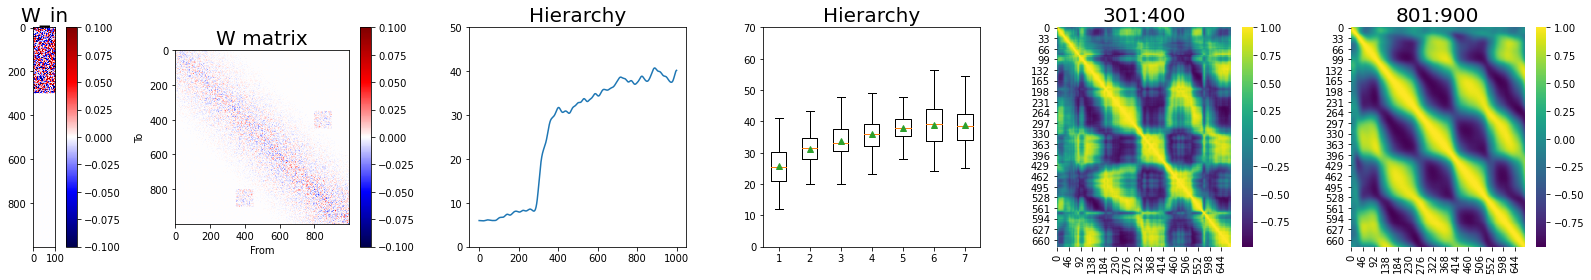

In [12]:

foo = np.mean(time_constants_n.T,axis=1)

fig= plt.figure(figsize=(24,4))
fs2=10
fs3=20

plt.subplot(161)
plt.imshow(esn._WInput,cmap='seismic',vmin=-0.1, vmax=0.1 )
plt.colorbar()
plt.title('W_in', fontsize=fs3)


plt.subplot(162)
plt.imshow(esn._W,cmap='seismic' ,vmin=-0.1, vmax=0.1)
plt.xlabel('From', fontsize=fs2)
plt.ylabel('To', fontsize=fs2)
plt.colorbar()

plt.title("W matrix", fontsize=fs3)
#plt.title("W", fontsize=fs3)

plt.subplot(163)
plt.plot(gaussian_filter1d(foo,sigma=10))
plt.title('Hierarchy', fontsize=fs3)
plt.ylim(0,50)

#plt.xlabel('Reservoir units Alignment Timed', fontsize=fs2)
#plt.ylabel('Alignment Time (TRs)', fontsize=fs2)
#plt.title('Temporal profiles of context construction alignment times', fontsize=fs3)

plt.subplot(165)
sns.heatmap(np.corrcoef(statesn[:,301:400]),  cmap='viridis')
plt.title('301:400', fontsize=fs3)

plt.subplot(166)
sns.heatmap(np.corrcoef(statesn[:,801:900]),  cmap='viridis')
plt.title('801:900', fontsize=fs3)


plt.subplot(164)
plt.ylim(0,70)
data=[foo[301:399],foo[401:499],foo[501:599],foo[601:699],foo[701:799],foo[801:899],foo[901:999]]
#plt.boxplot(data, showfliers=False,whis=[20, 50],showmeans=True)
plt.boxplot(data, showfliers=False,showmeans=True)
plt.title('Hierarchy', fontsize=fs3)

#fig.suptitle('Input shortcut pathway present', fontsize=16)

fig.tight_layout()
file_string = "comparison/final_mod_in_%s_mod_top%s_Direct_%s_%d.png" % (mod_input, mod_topo,radical,res_seed)
plt.savefig(file_string)


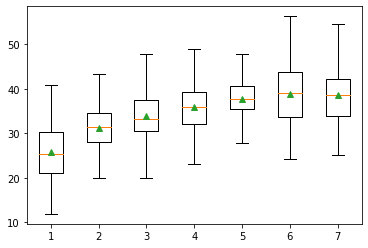

In [13]:
data=[foo[301:399],foo[401:499],foo[501:599],foo[601:699],foo[701:799],foo[801:899],foo[901:999]]
#plt.boxplot(data, showfliers=False,whis=[20, 50],showmeans=True)
plt.boxplot(data, showfliers=False,showmeans=True)
plt.show()

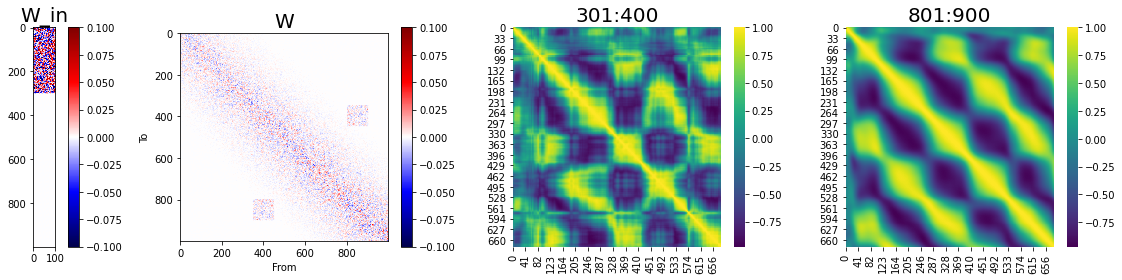

In [14]:
    
fig= plt.figure(figsize=(18,4))
fs2=10
fs3=20

plt.subplot(141)
plt.imshow(esn._WInput,cmap='seismic' ,vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title('W_in', fontsize=fs3)


plt.subplot(142)
plt.imshow(esn._W,cmap='seismic',vmin=-0.1, vmax=0.1 )
plt.xlabel('From', fontsize=fs2)
plt.ylabel('To', fontsize=fs2)
plt.colorbar()
plt.title('W', fontsize=fs3)

plt.subplot(143)
sns.heatmap(np.corrcoef(statesn[:,301:400]),  cmap='viridis')
plt.title('301:400', fontsize=fs3)

plt.subplot(144)
sns.heatmap(np.corrcoef(statesn[:,801:900]),  cmap='viridis')
plt.title('801:900', fontsize=fs3)


fig.tight_layout()
plt.savefig('comparison/control_topo.png')

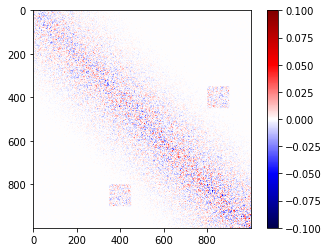

In [15]:
plt.imshow(esn._W,cmap='seismic',vmin=-0.1, vmax=0.1)
plt.colorbar()

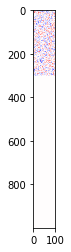

In [16]:
plt.imshow(esn._WInput,cmap='seismic' )

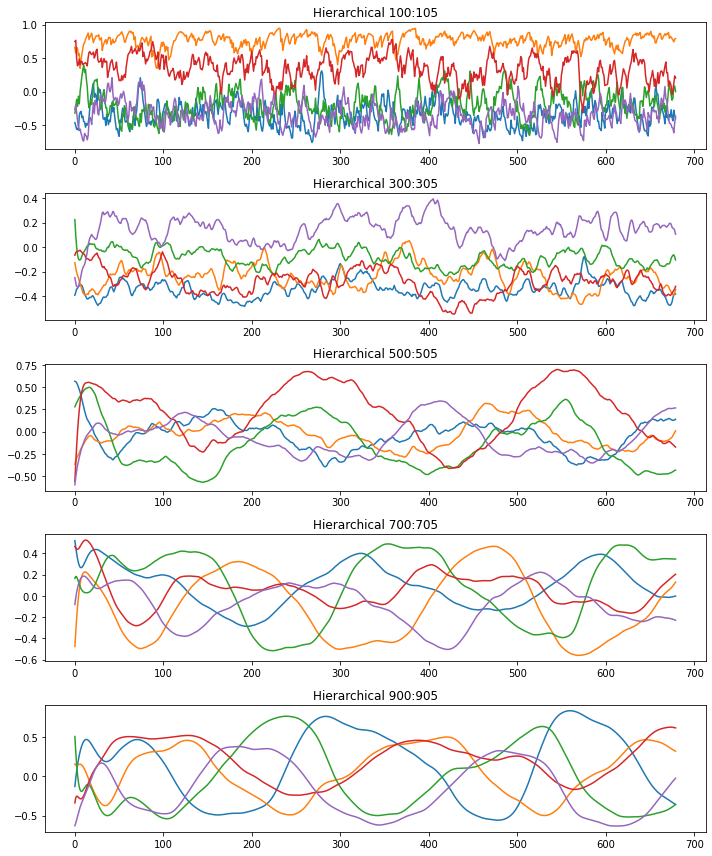

In [17]:
resn = 50
begin=0
end=680
rbegin = 900
rend = 910
fig= plt.figure(figsize=(10,12))

plt.subplot(511)
plt.plot( reservoirStatesBuffer[begin:end,100:105])
plt.title('Hierarchical 100:105')

plt.subplot(512)
plt.plot( reservoirStatesBuffer[begin:end,300:305])
plt.title('Hierarchical 300:305')

plt.subplot(513)
plt.plot( reservoirStatesBuffer[begin:end,500:505])
plt.title('Hierarchical 500:505')

plt.subplot(514)
plt.plot( reservoirStatesBuffer[begin:end,700:705])
plt.title('Hierarchical 700:705')

plt.subplot(515)
plt.plot( reservoirStatesBuffer[begin:end,900:905])
plt.title('Hierarchical 900:905')


fig.tight_layout()

plt.savefig('temporal_hierarchy.png')

In [18]:
print(radical)

associative


In [21]:
for i in range(areas): # create 10 sub areas
    for j in range (reservoirStatesBuffer1.shape[0]): #for each timestep
        roi_data[i,j] = np.mean(reservoirStatesBuffer1[j,i*factor:(i+1)*factor])

NameError: name 'reservoirStatesBuffer1' is not defined

In [ ]:
reservoirStatesBuffer1[j,i*factor:(i+1)*factor]

In [ ]:
plt.plot(roi_data.T)

plt.plot()

In [ ]:
plt.plot(roi_data[8:15,50:150].T)

plt.plot()

In [ ]:
source = 6
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[8,50:150].T)[:10],linewidth=1 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[10,50:150].T)[:10],linewidth=2 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[12,50:150].T)[:10],linewidth=3 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[14,50:150].T)[:10],linewidth=4 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[16,50:150].T)[:10],linewidth=5 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[18,50:150].T)[:10],linewidth=6 )
#plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[19,50:150].T)[:10],linewidth=7 )

In [ ]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(reservoirStatesBuffer1[700,50:150].T, reservoirStatesBuffer1[800,50:150].T, usevlines=True, maxlags=50, normed=True)
ax1.grid(True)

ax2.acorr(reservoirStatesBuffer1[16,50:150].T, usevlines=True, normed=True, maxlags=50)
ax2.grid(True)

plt.show()

In [ ]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(roi_data[7,50:150].T, roi_data[16,50:150].T, usevlines=False, maxlags=50, normed=True)
ax1.grid(True)

ax2.acorr(roi_data[16,50:150].T, usevlines=False, normed=True, maxlags=50)
ax2.grid(True)

plt.show()




